# Reading and plotting WRF data using wrf-python and Xarray

* In this example the variable data and coordinates are split between files (don't ask me why WRF does this...)
* An in-memory netcdf file is created and fed into wrf-python (https://wrf-python.readthedocs.io/en/latest/)
* Once the WRF data is in an Xarray DataArray there are additional tools you can use to process the data (http://xarray.pydata.org/en/stable/)

In [18]:
from netCDF4 import Dataset
import wrf
import xarray as xr
import numpy as np
import cartopy.crs as crs

In [19]:
my_vars  = ['SPDUV10MEAN', 'V10MEAN', 'U10MEAN']
root_dir = '/data/fiss_aic/WRF/runA_2010'

### Extract infomation from two netCDF files (src + coord_file) and add to an empty netCDF Dataset (dst)

In [28]:
#################################
### Get variables and dimensions
#################################
### source
src = Dataset(root_dir+'/wrfxtrm_d02') 

### destination (tmp netCDF file stored in memory) - close first if exists
### close in-memory netCDF Dataset (if exists)
try:
    print('>> closing dst << \n')
    dst.close()
except NameError:
    pass
dst = Dataset("dst_tmp.nc", "w", format="NETCDF4", diskless=True)

### copy netCDF attributes from source file to destination file
dst.setncatts(src.__dict__)

### copy all dimensions from src to dst
for name, dimension in src.dimensions.items():
    dst.createDimension(name, 
            len(dimension) if not dimension.isunlimited() else None)

>> closing dst << 



In [29]:
#################################
### Add time coordinates
#################################
name = 'Times'
variable = src.variables[name]
dst.createVariable(name, variable.datatype, variable.dimensions)
dst.variables[name][:] = src.variables[name][:]
dst[name].setncatts(src[name].__dict__)

# To do...
# create datetime object with units, units: days_sinceXXXX

In [30]:
#################################
### Add lat/lon coordinates
#################################
coord_file = Dataset(root_dir+'/wrfout_d02_2010-03-18_00:00:00')
coords = ['XLAT', 'XLONG']
for name in coords:
    variable = coord_file.variables[name]
    dst.createVariable(name, variable.datatype, variable.dimensions)
    
    ### create coord array with the correct shape (i.e. lat x lon for all times)
    correct_shape_arr = np.zeros( dst.variables[name].shape )
    correct_shape_arr[:,:,:] = coord_file.variables[name][0,:,:]
    
    dst.variables[name][:] = correct_shape_arr
    dst[name].setncatts(coord_file[name].__dict__)  

In [ ]:
#################################
### Extract any useful information 
### from nc file
#################################
nx = dst.dimensions['west_east'].size
ny = dst.dimensions['south_north'].size
dt, dx, dy = dst.DT, dst.DX, dst.DY
cen_lat, cen_lon = dst.CEN_LAT, dst.CEN_LON
truelat1, truelat2, STAND_LON = dst.TRUELAT1, dst.TRUELAT2, dst.STAND_LON
pole_lat, pole_lon = dst.POLE_LAT, dst.POLE_LON

In [ ]:
#################################
### Add south_north and west_east - WORK IN PROGRESS
#################################
x0_y0 = wrf.get_cartopy(wrfin=dst).transform_point( dst.variables['XLONG'][0,0,0], 
                                                    dst.variables['XLAT'][0,0,0], 
                                                    crs.PlateCarree())

west_east_points   = np.arange(nx, dtype='float32') * dy + x0_y0[0]
south_north_points = np.arange(ny, dtype='float32') * dy + x0_y0[1]

### Create nc variable
dst.createVariable('south_north', south_north_points.dtype, ('south_north') )
dst.variables['south_north'][:] = south_north_points
dst['south_north'].setncatts( {'units':'m', 'axis':'y'} )

dst.createVariable('west_east', west_east_points.dtype, ('west_east') )
dst.variables['west_east'][:] = west_east_points
dst['west_east'].setncatts( {'units':'m', 'axis':'x'} )

In [31]:
#################################
### copy chosen variables (my_var)
### from src to dst
#################################
for name in list(my_vars):
    variable = src.variables[name]
    dst.createVariable(name, variable.datatype, variable.dimensions)
    dst.variables[name][:] = src.variables[name][:]
    dst[name].setncatts(src[name].__dict__)

### Create an Xarray Dataset of WRF variables

In [9]:
### create list of variables in the Xarray DataArray format
da_list = []
for my_var in my_vars:
    da_list.append( wrf.getvar(dst, my_var, timeidx=wrf.ALL_TIMES) )

### merge all variables (Xarray DataArrays) into one Xarray Dataset
ds = xr.merge(da_list)
    
### Show me a summary of the Dataset...
ds

<xarray.Dataset>
Dimensions:      (Time: 380, south_north: 201, west_east: 147)
Coordinates:
    XLONG        (south_north, west_east) float32 -123.254684 ... -28.57109
    XLAT         (south_north, west_east) float32 -78.73641 ... -60.162468
  * Time         (Time) datetime64[ns] 2010-03-18 2010-03-19 ... 2011-04-01
Dimensions without coordinates: south_north, west_east
Data variables:
    SPDUV10MEAN  (Time, south_north, west_east) float32 0.0 0.0 ... 11.252552
    V10MEAN      (Time, south_north, west_east) float32 0.0 0.0 ... 8.698959
    U10MEAN      (Time, south_north, west_east) float32 0.0 0.0 ... -6.9788127

In [10]:
### Lets take a look at one of the available Data Variables
ds['V10MEAN']

<xarray.DataArray 'V10MEAN' (Time: 380, south_north: 201, west_east: 147)>
array([[[ 0.      ,  0.      , ...,  0.      ,  0.      ],
        [ 0.      ,  0.      , ...,  0.      ,  0.      ],
        ...,
        [ 0.      ,  0.      , ...,  0.      ,  0.      ],
        [ 0.      ,  0.      , ...,  0.      ,  0.      ]],

       [[-3.622793, -3.778482, ...,  2.431651,  2.353884],
        [-3.927514, -3.951676, ...,  2.301261,  2.283177],
        ...,
        [ 6.447971,  6.405501, ..., -4.847765, -4.90662 ],
        [ 6.461829,  6.373167, ..., -4.831599, -4.854212]],

       ...,

       [[-2.211912, -3.1217  , ..., -1.910759, -2.057363],
        [-2.66988 , -3.445264, ..., -2.124194, -2.335958],
        ...,
        [-2.937394, -2.638966, ...,  2.557832,  2.295851],
        [-2.703911, -2.514736, ...,  2.286338,  2.118749]],

       [[-4.04301 , -4.363912, ...,  0.03771 , -0.152135],
        [-3.997192, -4.27341 , ..., -0.29871 , -0.508273],
        ...,
        [ 1.181164,  1.64776

In [10]:
### close in-memory netCDF Dataset (if exists)
try:
    print('>> closing dst << \n')
    dst.close()
except NameError:
    pass

>> closing dst << 



### Contour Plots

In [11]:
import matplotlib
from matplotlib.cm import get_cmap
import matplotlib.pyplot as plt
import cartopy.feature as cfe

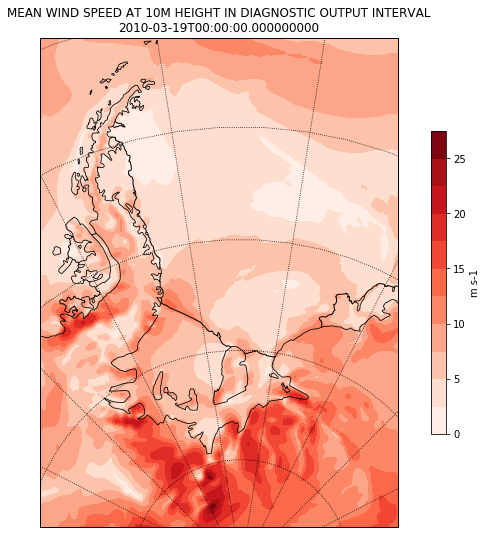

In [12]:
# select 2nd time instance
windspeed = ds['SPDUV10MEAN'].isel(Time=1)

# Get the latitude and longitude points
lats, lons = wrf.latlon_coords(windspeed)

# Get the cartopy mapping object
cart_proj = wrf.get_cartopy(windspeed)

# Create a figure
fig = plt.figure(figsize=(12,9))
# Set the GeoAxes to the projection used by WRF
ax = plt.axes(projection=cart_proj)

# Add coastlines
ax.coastlines('50m', linewidth=0.8)
ax.add_feature(cfe.NaturalEarthFeature('physical', 'antarctic_ice_shelves_lines', 
                                       '50m', linewidth=1.0, edgecolor='k', facecolor='none') )

# Plot contours
plt.contourf(wrf.to_np(lons), wrf.to_np(lats), wrf.to_np(windspeed), 10, 
                transform=crs.PlateCarree(), cmap=get_cmap("Reds"))

# Add a color bar
cbar = plt.colorbar(ax=ax, shrink=.62)
cbar.set_label(windspeed.units)

# Set the map limits.  Not really necessary, but used for demonstration.
ax.set_xlim(wrf.cartopy_xlim(windspeed))
ax.set_ylim(wrf.cartopy_ylim(windspeed))

# Add the gridlines
ax.gridlines(color="black", linestyle="dotted")

plt.title(windspeed.description+'\n'+str(windspeed.Time.values))

print('')

### Wind Vectors Plots - WORK IN PROGRESS!! 

WARNING: These can be tricky to correctly produce as the U/V vectors related to the WRF grid, where as we want to plot vectors on a lon/lat grid 

It is always worth checking that what you produce is sensible, e.g., by visually comparing to ERA-Interim

In [48]:
### Select the 2nd time instance from the U10MEAN DataArray, which is stored in the Dataset (ds)
uwind = ds['U10MEAN'].isel(Time=1)
vwind = ds['V10MEAN'].isel(Time=1)

### Create earth-rotated Dataset
# https://wrf-python.readthedocs.io/en/latest/user_api/generated/wrf.uvmet.html
cone = 1 # ???
uv   = wrf.uvmet(uwind, vwind, uwind.XLONG, uwind.XLAT, 
                     cen_lon, cone, meta=True, units='m s-1')

uv

<xarray.DataArray 'uvmet' (u_v: 2, south_north: 201, west_east: 147)>
array([[[  4.682425,   4.59302 , ..., -13.42942 , -13.071992],
        [  4.487749,   4.432105, ..., -13.444119, -13.185116],
        ...,
        [  5.371229,   5.28831 , ...,  -3.301146,  -3.336162],
        [  5.3394  ,   5.282778, ...,  -2.913351,  -2.955038]],

       [[ -6.787765,  -6.935503, ...,  -5.469786,  -5.302561],
        [ -7.023786,  -7.039359, ...,  -5.621724,  -5.44525 ],
        ...,
        [  5.587983,   5.556378, ...,  -4.300183,  -4.354916],
        [  5.616661,   5.533335, ...,  -4.362937,  -4.379314]]], dtype=float32)
Coordinates:
  * u_v      (u_v) <U1 'u' 'v'
Dimensions without coordinates: south_north, west_east
Attributes:
    units:        m s-1
    description:  earth rotated u,v

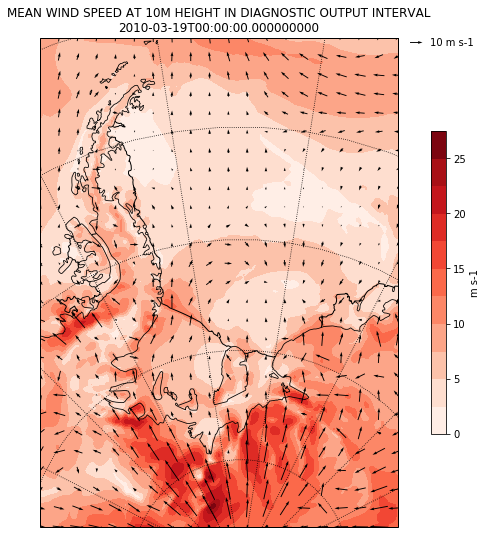

In [52]:
fig = plt.figure(figsize=(12,9))
# Set the GeoAxes to the projection used by WRF
cart_proj = wrf.get_cartopy(windspeed)
ax = plt.axes(projection=cart_proj)

# Add coastlines
ax.coastlines('50m', linewidth=0.8)
ax.add_feature(cfe.NaturalEarthFeature('physical', 'antarctic_ice_shelves_lines', '50m', 
                                           linewidth=1.0, edgecolor='k', facecolor='none'))

# Plot the wind speed as a contour plot
plt.contourf(wrf.to_np(lons), wrf.to_np(lats), wrf.to_np(windspeed), 10, 
                transform=crs.PlateCarree(), cmap=get_cmap("Reds"))

# Add a color bar
cbar = plt.colorbar(ax=ax, shrink=.62)
cbar.set_label(windspeed.units)

# Set the map limits.  Not really necessary, but used for demonstration.
ax.set_xlim(wrf.cartopy_xlim(windspeed))
ax.set_ylim(wrf.cartopy_ylim(windspeed))

# Add the gridlines
ax.gridlines(color="black", linestyle="dotted")

plt.title(windspeed.description+'\n'+str(windspeed.Time.values))

# Add arrows to show the wind vectors !!!!
x = uwind.XLONG.values
y = uwind.XLAT.values
u = uv[0].values
v = uv[1].values

Q = plt.quiver( x, y, u, v, 
               pivot='middle', 
               transform=crs.PlateCarree(), 
               regrid_shape=20 
               )

### plot quiver key
qk = plt.quiverkey(Q, 
                   1.07, 0.99,                  # x,y label position
                   10, str(10)+' '+uwind.units, # choose units + update string
                   labelpos='E',                # add label to the right
                   coordinates='axes'
                   )